# ECS7026P Neural Networks and Deep Learning - 2022/23 : Coursework 1


    Name: Mohammed Ataaur Rahaman
    Student Number: 220843052
    email: m.a.rahaman@se22.qmul.ac.uk
    Assignment Number: Coursework 1
    Module Code: ECS6P9U/P/7026P
    Module Name: Neural Networks and Deep Learning 
    
---

**Requirements**

Install graphviz, if pip doesn't work try conda install


`!conda install python-graphviz -y`

In [1]:
# To draw Model 
!pip install graphviz

In [2]:
# To Visualize layers
!pip install torchview

In [3]:
# To Log progress in a pretty way
!pip install progress-table

In [4]:
# Check GPU
!nvidia-smi

Thu Apr 13 19:57:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:17:00.0 Off |                    0 |
|  0%   51C    P0   186W / 300W |   3309MiB /  5067MiB |     58%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

---
#### Imports 

In [5]:
# Visualization
import matplotlib.pyplot as plt
from torchview import draw_graph
from progress_table import ProgressTable
from tqdm.auto import tqdm

# Time
from datetime import datetime
from dateutil import relativedelta

# Modeling
import numpy as np
import torch
import torchvision
from torch import nn

## 1. Data Gathering & Pre-Processing

### 1.1 Channel wise Data Normalization

In [7]:
# Download Dataset, as train and test.

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, )
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, )

Files already downloaded and verified
Files already downloaded and verified


Calculate mean and standard deviation of Train set per channel (red, green, blue) for standardization.

In [8]:
data = trainset.data / 255
rgb_mean_n_std = data.mean(axis=(0, 1, 2)), data.std(axis=(0, 1, 2))

print(f"Mean : {rgb_mean_n_std[0]}\nStandard Deviation : {rgb_mean_n_std[1]}")

Mean : [0.49139968 0.48215841 0.44653091]
Standard Deviation : [0.24703223 0.24348513 0.26158784]


### 1.2 Data Augmentation
Training data variations are created by data Augmentation. Like: 

	- Random Crop
    - Random Horizontal Flip
    - Random Rotation
    - Normalization
    
    
Note : Transformations type : https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

In [11]:
# Init transforms for train
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
    torchvision.transforms.RandomHorizontalFlip(), 
    torchvision.transforms.RandomRotation(degrees=(-25, 25)),
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize(*rgb_mean_n_std,inplace=True)  # Normalization
])

# Init transforms for test (only standardization)
transform_val = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(*rgb_mean_n_std)])

In [12]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val)

trainset, testset

Files already downloaded and verified
Files already downloaded and verified


(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                RandomCrop(size=(32, 32), padding=4)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-25.0, 25.0], interpolation=nearest, expand=False, fill=0)
                ToTensor()
                Normalize(mean=[0.49139968 0.48215841 0.44653091], std=[0.24703223 0.24348513 0.26158784])
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=[0.49139968 0.48215841 0.44653091], std=[0.24703223 0.24348513 0.26158784])
            ))

### 1.3 Data Loader

In [13]:
BATCH_SIZE = 4
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

### 1.4 Check data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


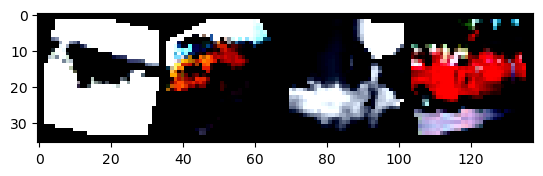

plane truck cat   truck


In [17]:
# Code reused from Pytorch Tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{CLASSES[labels[j]]:5s}' for j in range(BATCH_SIZE)))


In [18]:
# print size of data

images, labels = next(iter(trainloader))
_, IMG_CHANNELS, IMG_H, IMG_W = images.shape

print(f"{IMG_CHANNELS=}\n{IMG_H=}\n{IMG_W=}")

IMG_CHANNELS=3
IMG_H=32
IMG_W=32


## 2. Model Architecture

Given below is a basic required architecture.


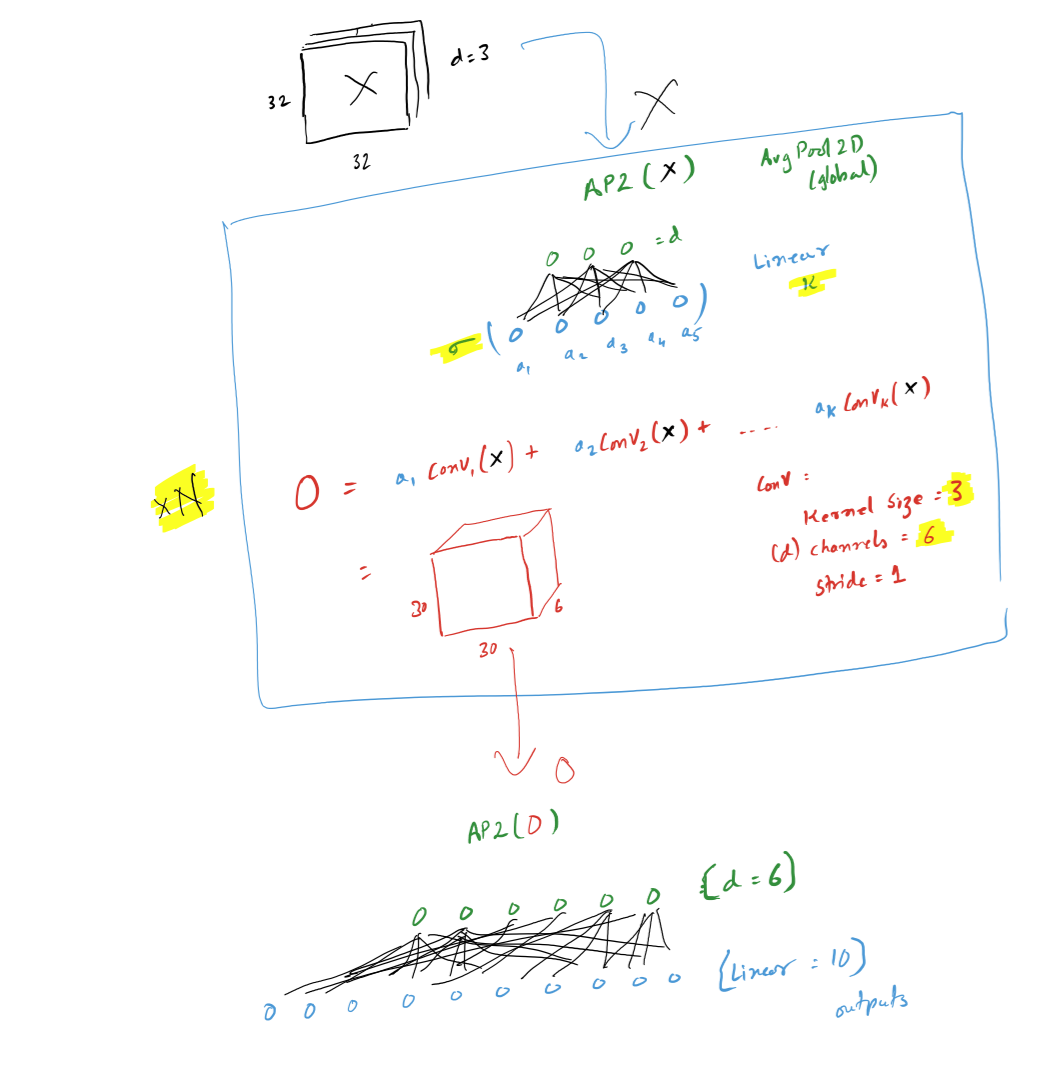

This architecture is further updated with additional parameters like dropouts, normalization etc to help aid in modeling.

### 2.1 ConvLayer

In [19]:
class ConvLayer(nn.Sequential):

    def __init__(self, in_channels, out_channels, kernel_size):
        """
        Convolution Layer.
        """
        
        super(ConvLayer, self).__init__(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=0),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout2d(p=0.2),
        )

### 2.2 ConvBlock

In [20]:
class ConvBlock(nn.Module):
    def __init__(self, channels, kernel_size):
        """
        Convolution block having len(channels) - 1 ConvLayers
        """
            
        super(ConvBlock, self).__init__()
        
        self.conv_block = nn.Sequential(*[
            ConvLayer(in_channels=channels[i], out_channels=channels[i+1], kernel_size=kernel_size)
            for i in range(len(channels) - 1)
        ])

    def forward(self, x):
        return self.conv_block(x)


### 2.3 Backbone

In [21]:
class Backbone(nn.Module):

    def __init__(self, channels, kernel_size, k, debug=False):
        """
        Backbone Block, having K ConvBlocks returning weighted sum. weights calculated using linear transformation of adaptiveAvgPool (spatial average pool).
        """
            
        super(Backbone, self).__init__()

        # Boolean to print debug logs.
        self.debug = debug

        self.spaitial_average_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        self.mlp = nn.Sequential(
            nn.Linear(in_features=channels[0], out_features=k, bias=True), 
            nn.Sigmoid(),      # Non Linear Activation
        )

        self.parallel_conv_blocks = nn.ModuleList([
            ConvBlock(channels=channels, kernel_size=kernel_size)
            for _ in range(k)
        ])

        self.batch_norm = nn.BatchNorm2d(num_features=channels[-1])

    def forward(self, x):
        sap_out = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
        if self.debug: print(f"{sap_out.shape=}")

        g_out = self.mlp(sap_out)
        if self.debug: print(f"{g_out.shape=}")
        if self.debug: print(f"{g_out=}")

        outs = list()
        for a, conv_block in zip(g_out.transpose(0, 1), self.parallel_conv_blocks):
            c_out = conv_block(x)
            if self.debug: print(f"{c_out.shape=}")
            if self.debug: print(f"{a.shape=}, \n{a=}")

            out = a.reshape(x.shape[0], 1, 1, 1)*c_out
            if self.debug: print(f"{out.shape=}")
            outs.append(out)

        out = sum(outs)
        if self.debug: print(f"{out.shape=}")

        out = self.batch_norm(out)
        if self.debug: print(f"batch_{out.shape=}")

        return out

### 2.4 Classifier

In [22]:
class Classifier(nn.Module):
    
    def __init__(self, in_features, out_features, debug=True):
        """
        Classifer, to classify the CIFAR 10 dataset. it has SpatialAveragePool and an linear layer.
        """
        super(Classifier, self).__init__()
        self.debug = debug
        
        self.spaitial_average_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        
        self.mlp = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=out_features, bias=True),
        )
        
    def forward(self, x):
        
        f = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
        if self.debug: print(f"Classifier: {f.shape=}")

        out = self.mlp(f)
        if self.debug: print(f"Classifier: {out.shape=}")

        return out

### 2.5 Model

In [23]:
class Model(nn.Module):
    
    def __init__(self, channels, Ks, kernel_size, n, debug=False):
        """
        Model, having N Backbones and a classifer.
        """
        super(Model, self).__init__()
        
        # Boolean to print debug logs.
        self.debug = debug 
        
        self.Ks = Ks
        self.channels = channels
        self.n = n

        self.backbones = nn.Sequential(*[
            Backbone(
                channels=self.channels[i],
                kernel_size=kernel_size, 
                k=self.Ks[i], 
                debug=debug
            ) 
            for i in range(self.n)
        ])
        
        self.classifier = Classifier(in_features=self.channels[-1][-1], out_features=len(CLASSES), debug=debug)

    @property
    def device(self):
        return next(self.parameters()).device
    
    def set_debug(self, debug=True):
        
        self.debug = debug
        for backbone in self.backbones:
            backbone.debug = debug
        self.classifier.debug = debug

    def forward(self, x):
        x = self.backbones(x)
        out = self.classifier(x)
        return out

## 3 Trainer

In [24]:
class Trainer:
    
    def __init__(self, model, criterion, optimizer, scheduler, trainloader, testloader, logs_per_epoch=4, grad_clip=None) -> None:
        """
        Trainer to help in training of the model.
        """
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.grad_clip = grad_clip
        
        self.epochs = 0
        self.log_step = len(trainloader) // logs_per_epoch if logs_per_epoch is not None else None

        self.trainloader = trainloader
        self.testloader = testloader
        
        self.lrs = list()
        self.losses = list()
        self.val_losses = list()
        self.batch_losses = list()

        self.train_accuracy = list()
        self.val_accuracy = list()
        
        self.history_table = self.get_history_table()
    
    @staticmethod
    def get_history_table():
        """
        Method to return ProgressTable.
        """
        history_table = ProgressTable(
            columns=["Epoch", "Time", "LR", "train_loss", "test_loss", "train_accuracy", "test_accuracy"],
            refresh_rate=10,
            num_decimal_places=8,
            default_column_width=12,
            default_column_alignment="center",
            print_row_on_update=True,
            reprint_header_every_n_rows=10,
            custom_format=None,
            embedded_progress_bar=False,
            table_style="ascii",  #['ascii', 'ascii_bare', 'normal', 'bare', 'bold', 'double', 'round']
        )
        history_table.add_column("Epoch", width=4)
        history_table.add_column("Time", width=12)
        history_table.add_column("LR", color=["BRIGHT", "RED"])
        history_table.add_column("train_loss", color=["BRIGHT", "BLUE"])
        history_table.add_column("test_loss", color=["BRIGHT", "YELLOW"])
        history_table.add_column("train_accuracy",color=["BRIGHT", "BLUE"])
        history_table.add_column("test_accuracy", color=["BRIGHT", "YELLOW"])
        return history_table
    
    def train(self, epochs=3, use_gpu=False):
        """
        Training Loop
        """
        # Start time of training
        start_time = datetime.now()
        
        for epoch in range(self.epochs, self.epochs + epochs):  # loop over the dataset multiple times

            # Epoch Start time
            start_time_ = datetime.now()
            
            batch_losses = list()
            running_loss = 0.0
            correct = 0
            total = 0
        
            
            # Set model to training.
            self.model.train()
            
            # Train loop
            for i, (images, labels) in self.history_table(enumerate(self.trainloader, 0), length=len(trainloader)):
                
                # Transfer data to device.
                images, labels = images.to(model.device), labels.to(model.device)

                # Zero the parameter gradients
                self.optimizer.zero_grad()

                # Forward + backward + optimize
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                if self.grad_clip is not None: nn.utils.clip_grad_value_(self.model.parameters(), self.grad_clip)
                self.optimizer.step()
                
                # Accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Print statistics
                batch_losses.append(loss.item())
                running_loss += loss.item()
                if self.log_step is not None and i % self.log_step == self.log_step-1:    # print every self.log_step mini-batches
                    avg_loss = running_loss / self.log_step
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}')
                    running_loss = 0.0
                    self.batch_losses.append(avg_loss)

            self.losses.append(sum(batch_losses) / len(batch_losses))
            
            # Calculate accuracy
            accuracy = correct / total
            self.train_accuracy.append(accuracy)
            
            # Save Learning rate.
            self.lrs.append(self.optimizer.param_groups[0]['lr'])
            
            val_loss, val_accuracy = self.eval()
            self.scheduler.step(val_loss)
            
            # Epoch End time
            rd = relativedelta.relativedelta(datetime.now(), start_time_)
            
            # Update history_table
            self.history_table["Epoch"] = epoch+1
            self.history_table["Time"] = f"{rd.minutes:2d}:{rd.seconds:2d}:{rd.microseconds}"
            self.history_table["LR"] = self.lrs[-1]
            self.history_table["train_loss"] = self.losses[-1]
            self.history_table["test_loss"] = val_loss
            self.history_table["train_accuracy"] = accuracy * 100
            self.history_table["test_accuracy"] = val_accuracy * 100
            self.history_table.next_row()
            
            #print(f"Epoch : {epoch+1:5d} | LR : {self.lrs[-1]:.8f} | Train Loss : {self.losses[-1]:.2f} | Train Accuracy : {100 * accuracy:.2f} | Test Loss : {val_loss:.2f} | Test Accuracy : {100 * val_accuracy:.2f}")
            
        self.epochs += epochs
        self.history_table.close()
        
        # End time
        rd = relativedelta.relativedelta(datetime.now(), start_time)
        print(f'Training Finished in "{rd.hours}Hrs {rd.minutes}mins {rd.seconds}secs {rd.microseconds}microsecs"')
    
    
    def eval(self):
        """
        Evaluation pipeline
        """
        correct = 0
        total = 0
        losses = list()
        
        # Set model to evaluation state
        self.model.eval()
        
        # Since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in self.testloader:
                images, labels = data
                if USE_GPU:
                    images = images.to('cuda')
                    labels = labels.to('cuda')

                # calculate outputs by running images through the network
                outputs = self.model(images)

                loss = self.criterion(outputs, labels)
                losses.append(loss.item())

                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Save Validation Loss
        val_loss = sum(losses) / len(losses)
        self.val_losses.append(val_loss)
        
        # Save Validation Accuracy
        accuracy = correct / total
        self.val_accuracy.append(accuracy)
        
        #print(f'Accuracy of the network on the 10000 test images: {100 * accuracy:.2f} %')
        
        return val_loss, accuracy
    
    def plot(self):
        """
        Plot curves
        
            1. Learning Rates
            2. Loss Curve
            3. Accuracy Curve
        """
        fig, (ax0, ax1, ax2) = plt.subplots(1, 3)
        fig.set_size_inches(15, 3)
        
        epochs_x = range(1, self.epochs+1)
        
        # Plot Learning Rate Curve
        ax0.plot(epochs_x, self.lrs, label="LR", color='C3', lw=3, alpha=1)
        ax0.legend()
        ax0.set_yscale('log')
        ax0.set(title=f'Learning Rates', xlabel='Epoch', ylabel='Learning rate')

        # Plot Loss Curve
        X = np.linspace(1, len(self.losses), len(self.batch_losses))
        ax1.plot(X, self.batch_losses, label="Train Batches", color='C0', linestyle='dashed', lw=1, alpha=0.7)
        ax1.plot(epochs_x, self.losses, label='Train', color='C0', lw=3, alpha=1)
        ax1.plot(epochs_x, self.val_losses, label='Test', color='C1', lw=3, alpha=1)
        ax1.legend()
        ax1.set(title=f'Loss Curve', xlabel='Epoch', ylabel='Loss')
        
        # Plot Accuracy Curve
        ax2.plot(epochs_x, self.train_accuracy, label="Train", color='C0', lw=3, alpha=1)
        ax2.plot(epochs_x, self.val_accuracy, label="Test", color='C1', lw=3, alpha=1)
        ax2.set(title=f'Accuracy Curve', xlabel='Epoch', ylabel='Accuracy')
        ax2.legend()
        
        plt.tight_layout()
        fig.show()
    

### 3.1 Helper methods 

In [25]:
def init_weights(m):
    """
    Helps initialize weights of linear and Conv2d layers.
    """
    if type(m) == nn.Linear or type(m) == nn.Conv2d: # by checking the type we can init different layers in different ways
        torch.nn.init.xavier_uniform_(m.weight)   

In [26]:
def model_summary(model, trainloader):
    """
    A wrapper method to help debug and understand the model paramters. 
    Importantly,
        1. it does one forward pass to calculate the image dimension when propogated to N Backbone. img_size = list()
        2. uses torchview.draw_graph to visualize the model graph.
    """
    
    # Get images and labels (batch 1) for forward pass.
    images, labels = next(iter(trainloader))
    images, labels = images.to(model.device), labels.to(model.device)
    
    # Forward pass to find image dimensions from input to the final ouput of Backbone.
    img_sizes = list()
    with torch.no_grad():
        x = images
        for backbone in model.backbones:
            img_sizes_ = list()
            img_sizes_.append(x.shape[-1])
            for conv_block in backbone.parallel_conv_blocks:
                for conv in conv_block.conv_block:
                    x = conv(x)
                    img_sizes_.append(x.shape[-1])
                break # Break out of parrallel blocks
            img_sizes.append(img_sizes_)
            
    # Print Stats
    print(f"{model.channels=}")
    print(f"{model.Ks=}")
    print(f"{model.n=}")
    print(f"{img_sizes=}")
    
    # Print ConvBlock Graph
    #for idx, backbone in enumerate(model.backbones):
    conv_block = model.backbones[0].parallel_conv_blocks[0]  # All blocks in prallel (k) are same, so just printing the first.
    graph = draw_graph(conv_block, input_size=images.shape, expand_nested=True, hide_module_functions=True, hide_inner_tensors=True, roll=False)
    print(f"\nConvBlock Graph (1):")
    display(graph.visual_graph)
    
    # Print Model Graph
    graph = draw_graph(model, input_size=images.shape, expand_nested=True, hide_module_functions=True, hide_inner_tensors=True, roll=False)
    print(f"\nModel Graph:")
    display(graph.visual_graph)

## 4. Training

### 4.1 Model init

model.channels=[[3, 128, 256], [256, 512, 1028]]
model.Ks=[3, 3]
model.n=2
img_sizes=[[32, 16, 8], [8, 4, 2]]

ConvBlock Graph (1):


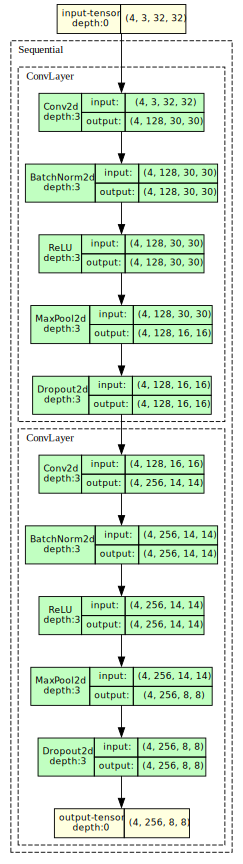


Model Graph:


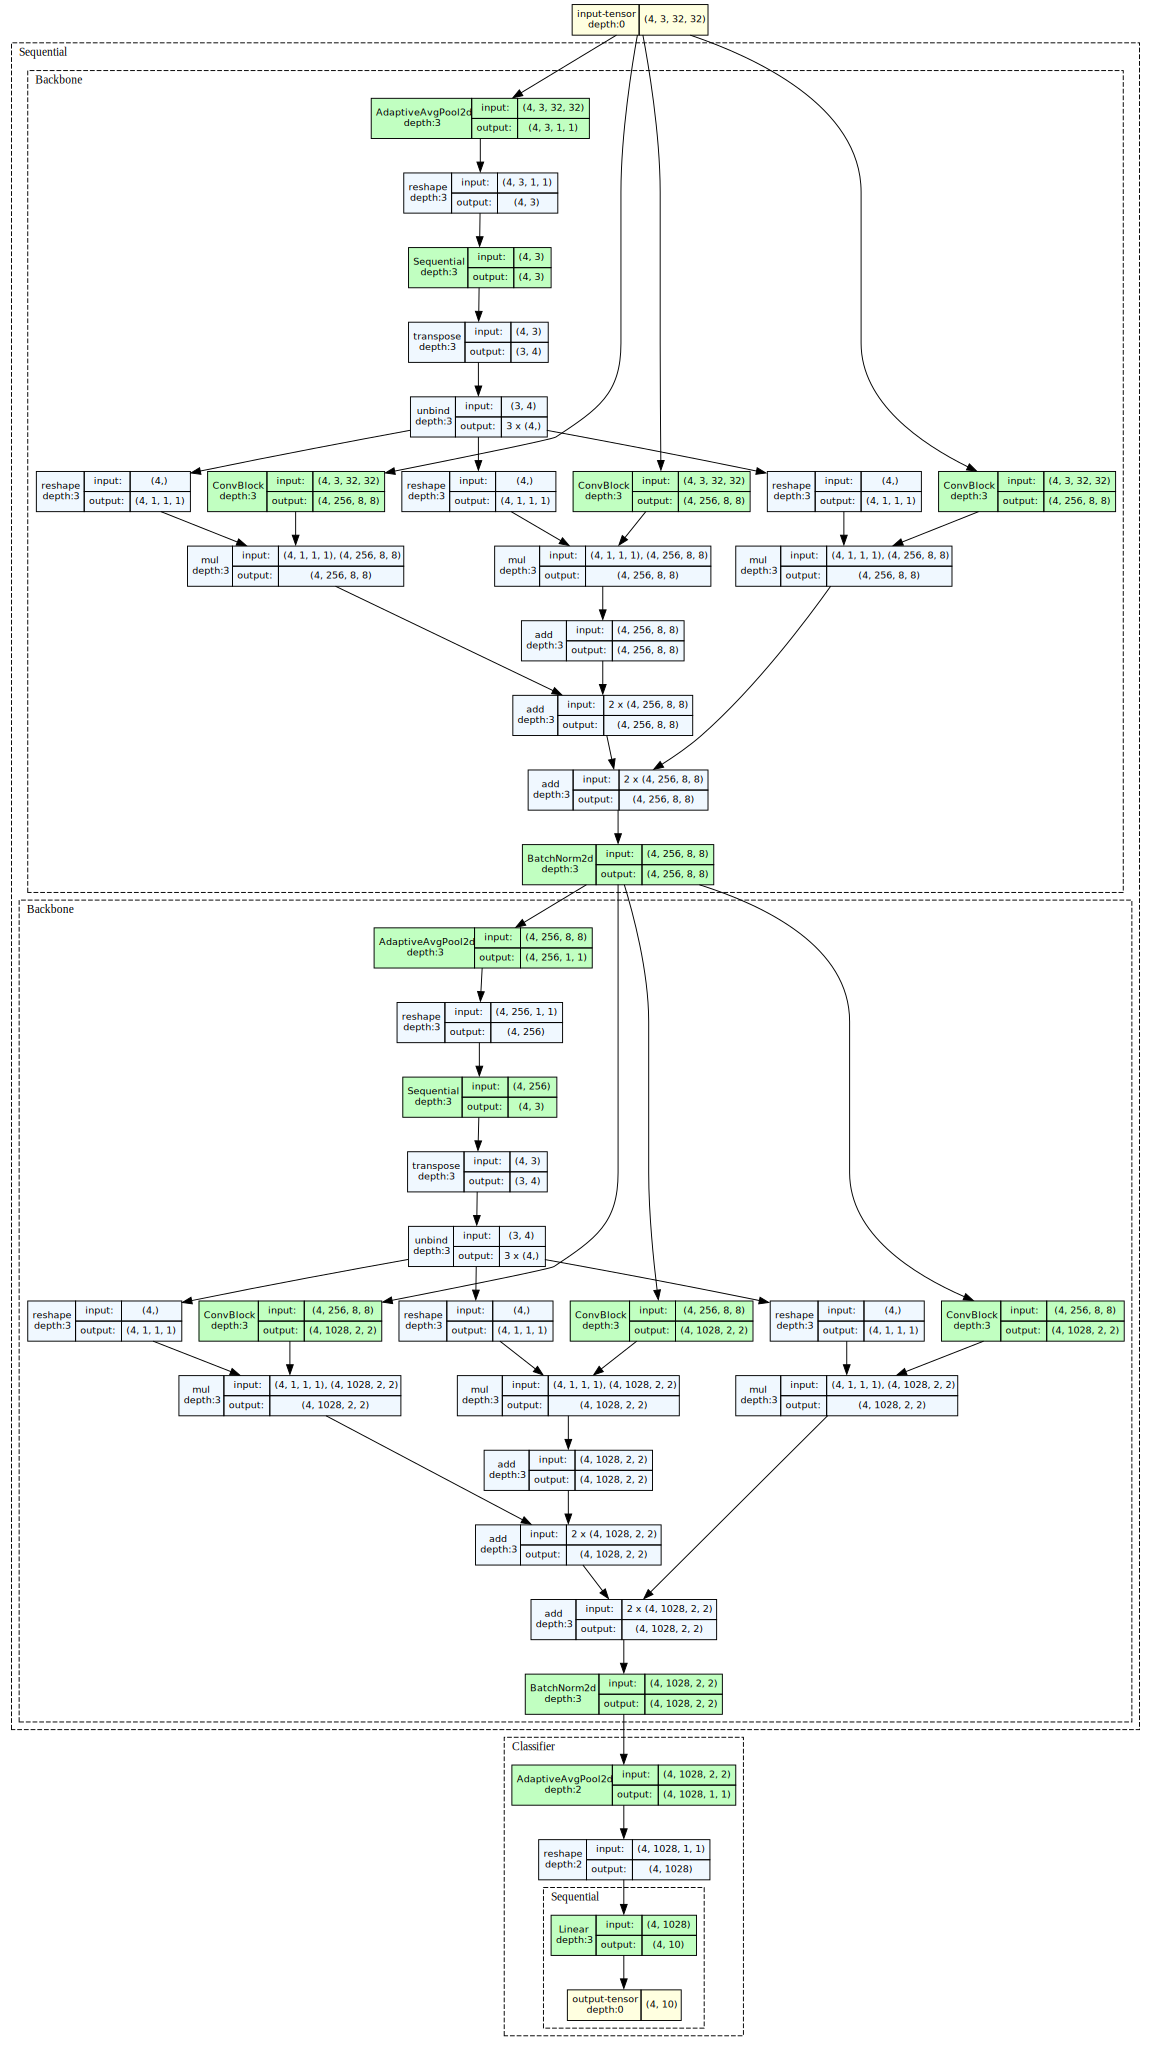

Model(
  (backbones): Sequential(
    (0): Backbone(
      (spaitial_average_pool): AdaptiveAvgPool2d(output_size=(1, 1))
      (mlp): Sequential(
        (0): Linear(in_features=3, out_features=3, bias=True)
        (1): Sigmoid()
      )
      (parallel_conv_blocks): ModuleList(
        (0): ConvBlock(
          (conv_block): Sequential(
            (0): ConvLayer(
              (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
              (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
              (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
              (4): Dropout2d(p=0.2, inplace=False)
            )
            (1): ConvLayer(
              (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
              (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
              (3): MaxPool2d(kernel_size=2, stride=

In [27]:
# Init model
USE_GPU = True
HIDDEN_CONV_KERNEL = 3


# Channels in each layer (backbone) is defined here. Each Backbone has M ConvLayers for its ConvBlock
channels = [[IMG_CHANNELS, 128, 256], [256, 512, 1028]]
N = len(channels)
Ks = [3] * N

model = Model(
    Ks=Ks,
    channels=channels,
    kernel_size=HIDDEN_CONV_KERNEL, 
    n=N, 
    debug=True
)

model.apply(init_weights)
if USE_GPU: model.to('cuda')
model.set_debug(False)

model_summary(model=model, trainloader=trainloader)
model

### 4.2 Loss Function

In [28]:
# Cross Entropy loss is used for classification problem
criterion = nn.CrossEntropyLoss()

### 4.3 Optimzer

In [29]:
# Init optimizer 
WEIGHT_DECAY = 1e-4 
LR = 1e-3

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

### 4.4 Learning Rate Schedulers

In [30]:
def visualise_lr(scheduler, epochs = 20):
    """
    Method to help visualize the Learning rate.
    """
    lrs_ = list()
    values = list(range(10, 0, -1)) + list(range(0, 20)) + [10]*5 + list(range(10, 0, -1)) + list(range(0, 10)) + list(range(10, 0, -1)) + list(range(0, 10)) + list(range(10, 0, -1))
    for i in range(epochs):
        optimizer.step()
        scheduler.step(values[i]) # pass values[i] for ReduceLROnPlateau 
        #scheduler.step()
        lrs_.append(optimizer.param_groups[0]['lr'])

    fig, ax = plt.subplots(1)
    ax.scatter(range(len(lrs_)), lrs_)
    ax.set_yscale('log')
    ax.set(xlabel="Epoch", ylabel="LR")
    fig.show()

    
def init_scheduler(optimizer, lr, scheduler_name):
    """
    Helper method to get a scheduler based on the scheduler name given.

    Note : All of these schedulers were tested for the experimentation, and reduce_on_plateau was choosen to be best.
    """
    schedulers = dict()
    
    schedulers["constant_scheduler"] = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=0.1, total_iters=20)
    schedulers["linear_scheduler"] = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.3333333333333333, end_factor=1.0, total_iters=50, last_epoch=- 1, verbose=False)
    schedulers["polynomial_scheduler"] = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=50, power=2.0, last_epoch=- 1, verbose=False)
    schedulers["exponential_scheduler"] = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    schedulers["step_scheduler"] = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    schedulers["cyclic_scheduler"] = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-6, max_lr=1e-4, step_size_up=5, step_size_down=None, mode='triangular', gamma=1.0, scale_fn=None, scale_mode='cycle', cycle_momentum=False, base_momentum=0.8, max_momentum=0.9, last_epoch=- 1, verbose=False)
    schedulers["one_cycle_scheduler"] = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, total_steps=None, epochs=20, steps_per_epoch=len(trainloader), pct_start=0.3, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=25.0, final_div_factor=10000.0, three_phase=False, last_epoch=-1, verbose=False)    
    schedulers["reduce_on_plateau_scheduler"] = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)

    schedulers["sequential_scheduler"] = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[schedulers["polynomial_scheduler"], schedulers["cyclic_scheduler"]], milestones=[20])#, last_epoch=60)

    optimizer.param_groups[0]['lr'] = lr
    
    return schedulers[scheduler_name]

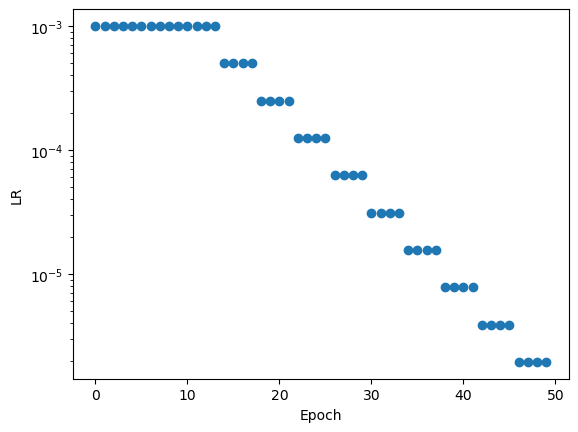

In [31]:
visualise_lr(scheduler=init_scheduler(optimizer=optimizer, lr=LR, scheduler_name="reduce_on_plateau_scheduler"), epochs=50)

### 4.5 Init Scheduler

In [32]:
scheduler = init_scheduler(optimizer=optimizer, lr=LR, scheduler_name="reduce_on_plateau_scheduler")

### 4.6 Init Trainer

In [33]:
# Init Trainer

BATCH_SIZE = 256

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


trainer = Trainer(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    logs_per_epoch=None,
    grad_clip=0.1,
    trainloader=trainloader,
    testloader=testloader,
)

### 4.7 Train

+-------+--------------+--------------+--------------+--------------+----------------+---------------+
| Epoch |     Time     |      LR      |  train_loss  |  test_loss   | train_accuracy | test_accuracy |
+-------+--------------+--------------+--------------+--------------+----------------+---------------+
|   1   |  0:51:636749 |  0.00100000  |  1.85296870  |  1.30335291  |  36.74200000   |  53.23000000  |
|   2   |  0:50:236341 |  0.00100000  |  1.45791949  |  1.13321394  |  48.40200000   |  59.64000000  |
|   3   |  0:51:719678 |  0.00100000  |  1.29619458  |  0.99699739  |  54.02600000   |  65.72000000  |
|   4   |  0:49:902029 |  0.00100000  |  1.18768217  |  0.87262187  |  58.26000000   |  69.66000000  |
|   5   |  0:51:699691 |  0.00100000  |  1.09883426  |  0.81588362  |  61.58800000   |  71.34000000  |
|   6   |  0:50:334574 |  0.00100000  |  1.04212791  |  0.79243972  |  63.46800000   |  72.29000000  |
|   7   |  0:50:681553 |  0.00100000  |  0.98375849  |  0.72364545  |  65

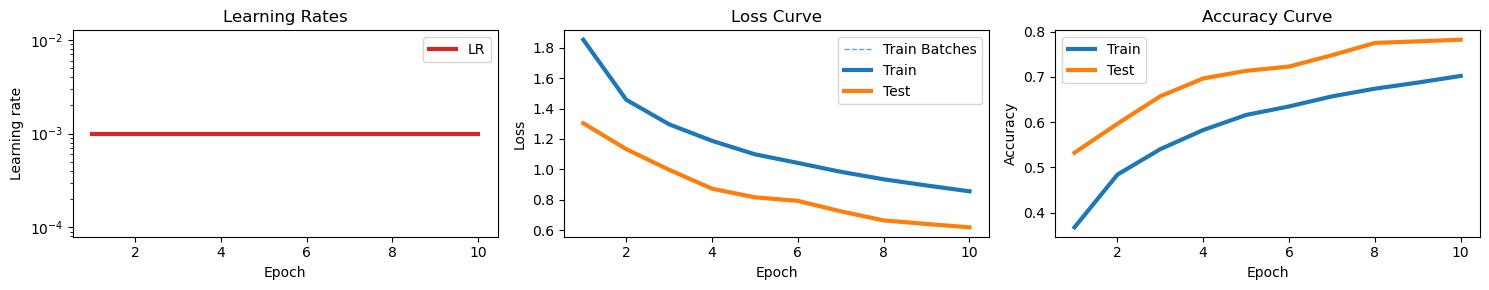

In [34]:
trainer.train(epochs=10, use_gpu=USE_GPU)
trainer.plot()

+-------+--------------+--------------+--------------+--------------+----------------+---------------+
| Epoch |     Time     |      LR      |  train_loss  |  test_loss   | train_accuracy | test_accuracy |
+-------+--------------+--------------+--------------+--------------+----------------+---------------+
|   11  |  0:48:441635 |  0.00100000  |  0.83470399  |  0.58837815  |  70.85000000   |  79.51000000  |
|   12  |  0:49:364274 |  0.00100000  |  0.80421848  |  0.57707743  |  72.02000000   |  80.06000000  |
|   13  |  0:48:870346 |  0.00100000  |  0.76855318  |  0.54858592  |  73.25200000   |  81.02000000  |
|   14  |  0:49:256694 |  0.00100000  |  0.74852632  |  0.55714628  |  73.72200000   |  81.25000000  |
|   15  |   0:49:6380  |  0.00100000  |  0.72420458  |  0.52722145  |  74.58800000   |  81.84000000  |
|   16  |  0:49:591529 |  0.00100000  |  0.71464602  |  0.52877464  |  74.75800000   |  81.65000000  |
|   17  |  0:48:423723 |  0.00100000  |  0.69192535  |  0.48936220  |  75

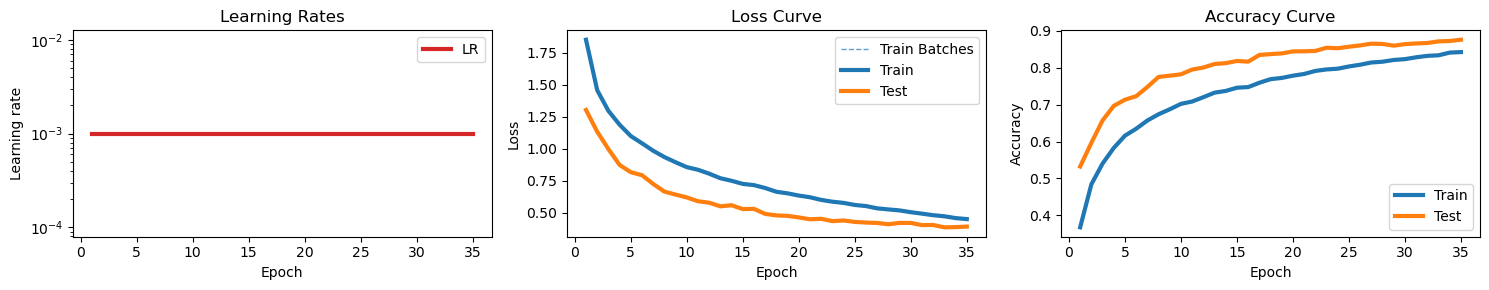

In [35]:
trainer.train(epochs=25, use_gpu=USE_GPU)
trainer.plot()

+-------+--------------+--------------+--------------+--------------+----------------+---------------+
| Epoch |     Time     |      LR      |  train_loss  |  test_loss   | train_accuracy | test_accuracy |
+-------+--------------+--------------+--------------+--------------+----------------+---------------+
|   36  |  0:50:214506 |  0.00100000  |  0.44068780  |  0.38367861  |  84.55200000   |  87.27000000  |
|   37  |  0:49:598940 |  0.00100000  |  0.43139298  |  0.37563369  |  84.99200000   |  87.54000000  |
|   38  |  0:50:176862 |  0.00100000  |  0.42034933  |  0.36483160  |  85.21800000   |  87.92000000  |
|   39  |  0:49:125861 |  0.00100000  |  0.41760400  |  0.36734607  |  85.29600000   |  88.08000000  |
|   40  |  0:51:895305 |  0.00100000  |  0.40598625  |  0.37027928  |  85.78400000   |  88.28000000  |
|   41  |  0:50:700888 |  0.00100000  |  0.39183617  |  0.36610367  |  86.22000000   |  88.33000000  |
|   42  |  0:49:531913 |  0.00100000  |  0.39095770  |  0.36631765  |  86

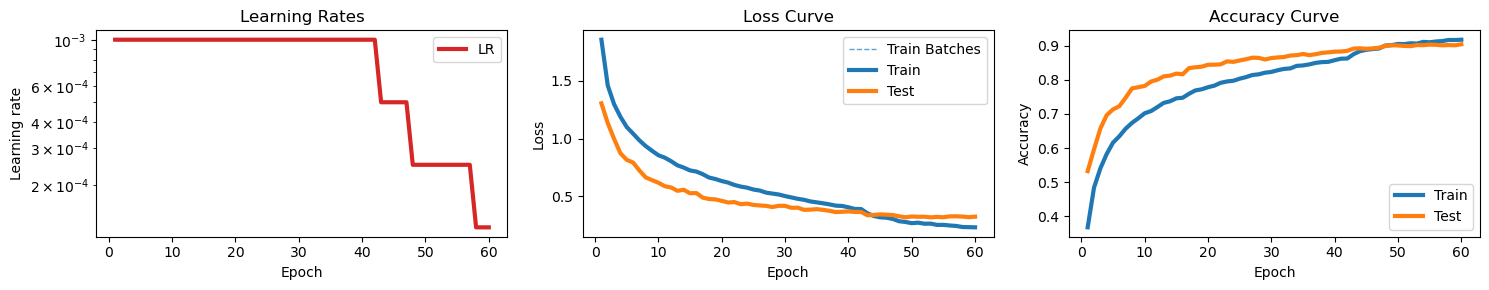

In [36]:
trainer.train(epochs=25, use_gpu=USE_GPU)
trainer.plot()

+-------+--------------+--------------+--------------+--------------+----------------+---------------+
| Epoch |     Time     |      LR      |  train_loss  |  test_loss   | train_accuracy | test_accuracy |
+-------+--------------+--------------+--------------+--------------+----------------+---------------+
|   61  |  0:49:946537 |  0.00012500  |  0.22841088  |  0.32282284  |  92.02400000   |  90.49000000  |
|   62  |  0:51:225746 |  0.00006250  |  0.22081682  |  0.32379240  |  92.38000000   |  90.49000000  |
|   63  |  0:50:208077 |  0.00006250  |  0.22117285  |  0.32446212  |  92.30800000   |  90.25000000  |
|   64  |  0:51:603953 |  0.00006250  |  0.22106475  |  0.32386799  |  92.27600000   |  90.44000000  |
|   65  |   0:50:256   |  0.00006250  |  0.21963576  |  0.32457284  |  92.41800000   |  90.48000000  |
|   66  |  0:50:825477 |  0.00003125  |  0.21772728  |  0.32385382  |  92.43000000   |  90.44000000  |
|   67  |  0:48:473129 |  0.00003125  |  0.21412594  |  0.32523231  |  92

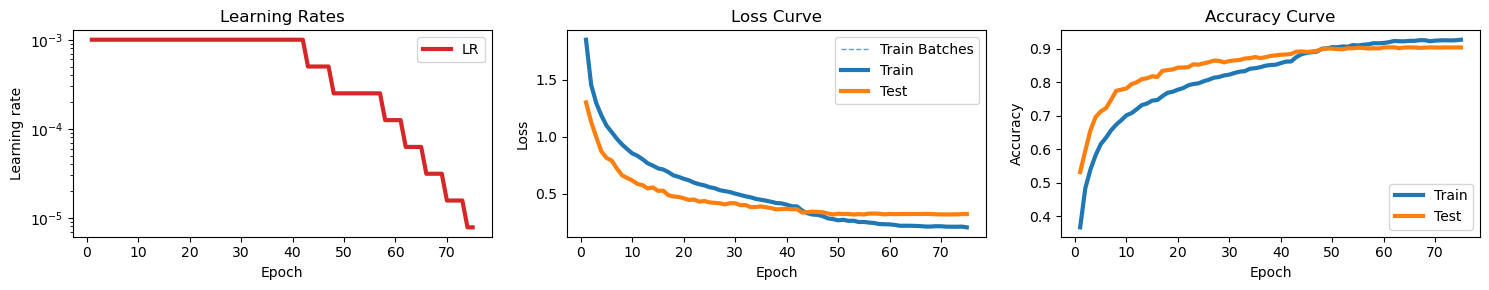

In [37]:
trainer.train(epochs=15, use_gpu=USE_GPU)
trainer.plot()

+-------+--------------+--------------+--------------+--------------+----------------+---------------+
| Epoch |     Time     |      LR      |  train_loss  |  test_loss   | train_accuracy | test_accuracy |
+-------+--------------+--------------+--------------+--------------+----------------+---------------+
|   76  |  0:49:891953 |  0.00000781  |  0.21212378  |  0.32055749  |  92.64200000   |  90.52000000  |
|   77  |  0:50:890148 |  0.00000781  |  0.20834961  |  0.32076916  |  92.67000000   |  90.52000000  |
|   78  |  0:49:252941 |  0.00000391  |  0.20577515  |  0.32093325  |  92.85600000   |  90.51000000  |
|   79  |  0:49:912020 |  0.00000391  |  0.21148325  |  0.31922919  |  92.66600000   |  90.43000000  |
|   80  |  0:48:443561 |  0.00000391  |  0.21121236  |  0.32274689  |  92.60200000   |  90.59000000  |
+-------+--------------+--------------+--------------+--------------+----------------+---------------+
Training Finished in "0Hrs 4mins 8secs 401904microsecs"


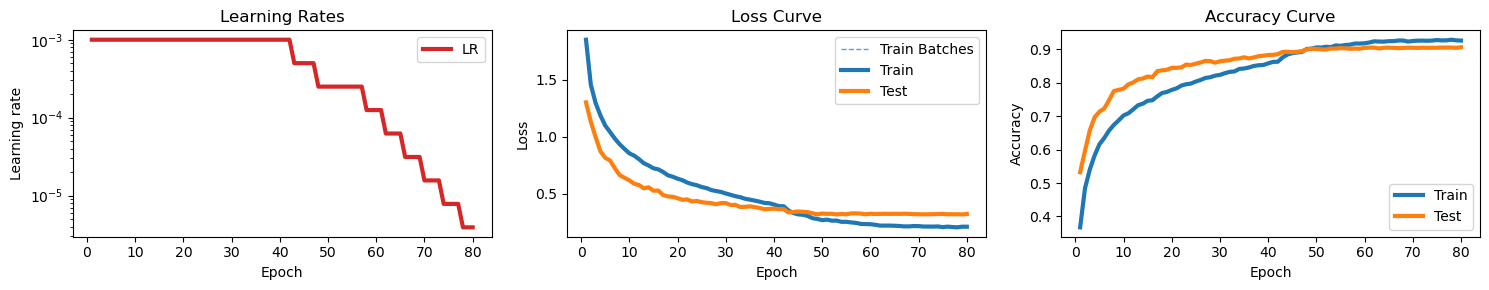

In [38]:
trainer.train(epochs=5, use_gpu=USE_GPU)
trainer.plot()

+-------+--------------+--------------+--------------+--------------+----------------+---------------+
| Epoch |     Time     |      LR      |  train_loss  |  test_loss   | train_accuracy | test_accuracy |
+-------+--------------+--------------+--------------+--------------+----------------+---------------+
|   81  |  0:50:527366 |  0.00000391  |  0.21275080  |  0.32167223  |  92.58400000   |  90.50000000  |
|   82  |  0:49:352530 |  0.00000195  |  0.21087515  |  0.32115668  |  92.74800000   |  90.34000000  |
|   83  |  0:51:549923 |  0.00000195  |  0.20750247  |  0.32166751  |  92.84000000   |  90.41000000  |
|   84  |  0:48:803487 |  0.00000195  |  0.20397019  |  0.32136102  |  92.83600000   |  90.45000000  |
|   85  |  0:50:992397 |  0.00000195  |  0.20748505  |  0.32310134  |  92.74600000   |  90.48000000  |
|   86  |  0:49:347830 |  0.00000098  |  0.20867665  |  0.32035821  |  92.88800000   |  90.48000000  |
|   87  |  0:50:843090 |  0.00000098  |  0.21020403  |  0.31898473  |  92

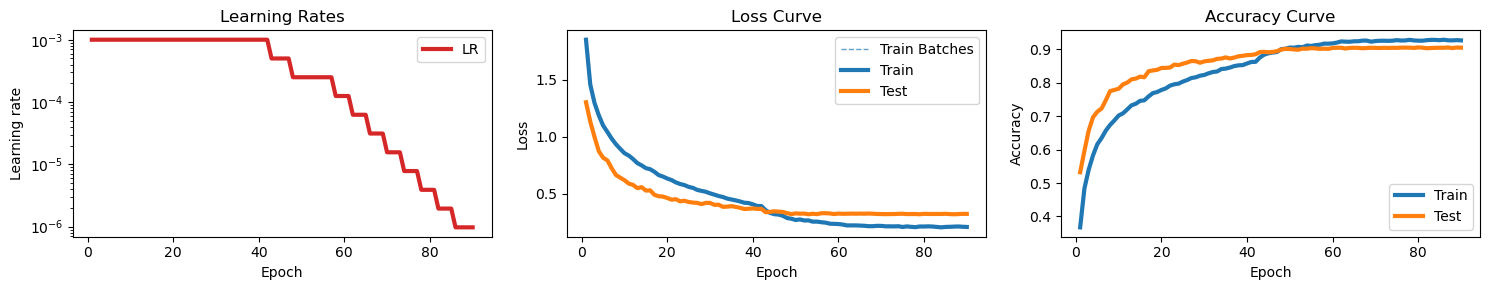

In [39]:
trainer.train(epochs=10, use_gpu=USE_GPU)
trainer.plot()

## Appendix

### ResNET Model: Experiment [Failed]

In [ ]:
# Code inspired from : https://www.kaggle.com/code/kmldas/cifar10-resnet-90-accuracy-less-than-5-min

class Conv(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, pool=True):
        """
        TODO
        """
            
        super(Conv, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1, padding=1),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
        )
        if pool: self.conv_layer.add_module("pool", nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
        
    def forward(self, x):
        return self.conv_layer(x)

    
class ResNet(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, pool=False, ):
        """
        TODO
        """
            
        super(ResNet, self).__init__()
        
        self.resnet = nn.Sequential(
            Conv(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, pool=pool),
            Conv(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, pool=pool)
        )
        
        
    def forward(self, x):
        return self.resnet(x) + x
    
class ConvBlock(nn.Module):
    def __init__(self, channels, kernel_size):
        """
        TODO
        """
            
        super(ConvBlock, self).__init__()
        
        self.conv_block = nn.Sequential(
            Conv(in_channels=channels[0], out_channels=channels[1], kernel_size=kernel_size, pool=False),
            Conv(in_channels=channels[1], out_channels=channels[2], kernel_size=kernel_size, pool=True),
            ResNet(in_channels=channels[2], out_channels=channels[2], kernel_size=kernel_size, pool=False),
            Conv(in_channels=channels[2], out_channels=channels[3], kernel_size=kernel_size, pool=True),
            Conv(in_channels=channels[3], out_channels=channels[4], kernel_size=kernel_size, pool=True),
            ResNet(in_channels=channels[4], out_channels=channels[4], kernel_size=kernel_size, pool=False),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
    def forward(self, x):
        #return self.relu(self.batch_norm(self.conv_block(x) + self.conv(x)))
        return self.conv_block(x)


## Thank you